A big data re-implemenation of a supervised learning project

# Small Business Administration - Predicting Loan Default
<br/>
  The following code uses the cleaned and prepared data created in the accompanying data cleaning notebook. Changes to the data cleaning were made, and the difference was compared with the best classifier. If running cells, be sure the appropriate data is currently in memory (including variables). 

<br/>

  The best model was Gradient Boosting Classifier. Accuracy, precision, and recall were 0.88, 0.68, 0.95. This was done with down sampled data to address an imbalance of the target class. Precision was deliberately cut to increase recall, as identifying a loan that will default is more important than identifying a loan that will be paid off, as the SBA is responsible for a portion of these defaulted laons. Important features seemed to be related to prescreening-like metrics and business growth. 

<br/>

  Some features were deliberately dropped, such as the amounth the SBA gaurenteed. This problem is framed in the context of deciding whether the SBA should back a loan, so any information dependent on this decision was excluded. 

<br/>


Several other models, such as random forests and logistic regression were tried, but were outperformed by the XGBoost Classifier.
<br/>
* SBA Link: https://www.sba.gov/offices/headquarters/ofa/resources/11421
* Link to original Kaggle set: https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied


In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import LeaveOneOutEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    fbeta_score,
    plot_confusion_matrix,
    plot_precision_recall_curve,
    plot_roc_curve,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Replace with whatever model import(s) you're using
from xgboost import XGBClassifier


%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

<IPython.core.display.Javascript object>

In [3]:
import dask
import dask.dataframe as dd
import joblib

<IPython.core.display.Javascript object>

In [4]:
# setting up dask
import warnings

warnings.filterwarnings("ignore")

from dask.distributed import Client, progress

# client = Client(n_workers=4, threads_per_worker=2, memory_limit="2GB")
# client

<IPython.core.display.Javascript object>

In [5]:
def print_vif(x, cols):
    import warnings
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x, i)
        vifs.append(vif)

    cols = cols.insert(0, "Const")
    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=cols))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

### Loading in the data. Two methods were done to clean, and the best model compared the two. The second cleaning is the better data.

In [6]:
# the data was cleaned twice.
# loans = pd.read_csv("data/sba_loans_cleaned2.csv")
# loans.info()

# loans2 = pd.read_csv("data/sba_loans_cleaned3.csv")

loans = dd.read_csv("data/sba_loans_cleaned3.csv")

<IPython.core.display.Javascript object>

In [7]:
loans.head()

,State,BankState,ApprovalFY,NoEmp,NewExist,RevLineCr,LowDoc,DisbursementGross,MIS_Status,twoDigNAICS,is_franchise,bank_out_of_state,Term_years,job_category,retained_category,UrbanRural_cleaned,Disbr_year,Disbr_Month_sin,Disbr_Month_cos,sba_pre_approv,percent_SBA,bank_size,Appv_Month_sin,Appv_Month_cos
0,NC,MN,2006,2,1,0.0,0.0,253400.0,0,44,1.0,0,13.500000,0.0,0.0,0.0,2006,0.866025,5.000000e-01,1.0,0.75,1.0,0.5,0.866025
1,AR,MS,2006,7,0,0.0,0.0,137300.0,0,72,0.0,0,10.500000,0.0,0.0,0.0,2006,1.000000,6.123234e-17,1.0,0.85,0.0,0.5,0.866025
2,CA,SD,2006,18,1,1.0,0.0,438541.0,0,61,0.0,0,6.916667,1.0,2.0,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
3,FL,FL,2006,4,0,1.0,0.0,51440.0,0,23,0.0,1,7.000000,0.0,1.0,0.0,2006,0.500000,8.660254e-01,1.0,0.50,2.0,0.5,0.866025
4,LA,LA,2006,3,0,0.0,0.0,50000.0,0,53,0.0,1,5.000000,0.0,0.0,0.0,2006,0.866025,-5.000000e-01,1.0,0.85,0.0,0.5,0.866025


<IPython.core.display.Javascript object>

In [8]:
cat_cols = [
    "State",
    "BankState",
    "twoDigNAICS",
]

ordinal_cols = [
    "job_category",
    "retained_category",
    "bank_size",
]

num_cols = [
    # "ApprovalFY",
    "NoEmp",
    "DisbursementGross",
    "Term_years",  # untapped potential here
    "Disbr_year",  # may want to do some grouping by or transformation
]

bin_cols = ["NewExist", "is_franchise", "bank_out_of_state", "sba_pre_approv"]

other_cols = [
    "Disbr_Month_sin",
    "Disbr_Month_cos",
    "Appv_Month_sin",
    "Appv_Month_cos",
]  # not used, just documenting all cols

# information that won't exist until a decision is made by the SBA
sba_cols = [
    "Appv_Month_sin",
    "Appv_Month_cos",
    "sba_pre_approv",
    "percent_SBA",
    "ApprovalFY",
]  # turn off for loans

# impute_cols = [
#     "RevLineCr",
#     "LowDoc",
#     "UrbanRural_cleaned",
# ]

# dropping na's until the imputer is working
loans = loans.dropna()
# loans2 = loans2.dropna()

<IPython.core.display.Javascript object>

In [9]:
loans.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510160 entries, 0 to 89019
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   State               510160 non-null  object 
 1   BankState           510160 non-null  object 
 2   ApprovalFY          510160 non-null  int64  
 3   NoEmp               510160 non-null  int64  
 4   NewExist            510160 non-null  int64  
 5   RevLineCr           510160 non-null  float64
 6   LowDoc              510160 non-null  float64
 7   DisbursementGross   510160 non-null  float64
 8   MIS_Status          510160 non-null  int64  
 9   twoDigNAICS         510160 non-null  int64  
 10  is_franchise        510160 non-null  float64
 11  bank_out_of_state   510160 non-null  int64  
 12  Term_years          510160 non-null  float64
 13  job_category        510160 non-null  float64
 14  retained_category   510160 non-null  float64
 15  UrbanRural_cleaned  510160 non-null

<IPython.core.display.Javascript object>

In [10]:
X = loans.drop(columns="MIS_Status")
y = loans["MIS_Status"]

X.persist()
y.persist()

Dask Series Structure:
npartitions=2
    int64
      ...
      ...
Name: MIS_Status, dtype: int64
Dask Name: getitem, 2 tasks

<IPython.core.display.Javascript object>

In [11]:
X.npartitions

2

<IPython.core.display.Javascript object>

In [12]:
y.npartitions

2

<IPython.core.display.Javascript object>

In [13]:
X.isna().sum().compute()

State                 0
BankState             0
ApprovalFY            0
NoEmp                 0
NewExist              0
RevLineCr             0
LowDoc                0
DisbursementGross     0
twoDigNAICS           0
is_franchise          0
bank_out_of_state     0
Term_years            0
job_category          0
retained_category     0
UrbanRural_cleaned    0
Disbr_year            0
Disbr_Month_sin       0
Disbr_Month_cos       0
sba_pre_approv        0
percent_SBA           0
bank_size             0
Appv_Month_sin        0
Appv_Month_cos        0
dtype: int64

<IPython.core.display.Javascript object>

In [14]:
X_cols = X.select_dtypes(include="number").columns

<IPython.core.display.Javascript object>

In [15]:
X_cols.insert(0, "const")

Index(['const', 'ApprovalFY', 'NoEmp', 'NewExist', 'RevLineCr', 'LowDoc',
       'DisbursementGross', 'twoDigNAICS', 'is_franchise', 'bank_out_of_state',
       'Term_years', 'job_category', 'retained_category', 'UrbanRural_cleaned',
       'Disbr_year', 'Disbr_Month_sin', 'Disbr_Month_cos', 'sba_pre_approv',
       'percent_SBA', 'bank_size', 'Appv_Month_sin', 'Appv_Month_cos'],
      dtype='object')

<IPython.core.display.Javascript object>

In [16]:
X_cols

Index(['ApprovalFY', 'NoEmp', 'NewExist', 'RevLineCr', 'LowDoc',
       'DisbursementGross', 'twoDigNAICS', 'is_franchise', 'bank_out_of_state',
       'Term_years', 'job_category', 'retained_category', 'UrbanRural_cleaned',
       'Disbr_year', 'Disbr_Month_sin', 'Disbr_Month_cos', 'sba_pre_approv',
       'percent_SBA', 'bank_size', 'Appv_Month_sin', 'Appv_Month_cos'],
      dtype='object')

<IPython.core.display.Javascript object>

In [17]:
X.select_dtypes(include="number").compute().shape

(510160, 21)

<IPython.core.display.Javascript object>

In [18]:
len(X.select_dtypes(include="number").columns)

21

<IPython.core.display.Javascript object>

In [19]:
# had to add passing the columns to vif function
# dask uses arrays and arrays don't have col names!
# likewise had to add 'const' to the list in the f(x)

%time print_vif(X.select_dtypes(include="number"), X.select_dtypes(include="number").columns)

VIF results
-------------------------------
Const                 814042.869130
ApprovalFY                23.896407
NoEmp                      1.030941
NewExist                   1.116227
RevLineCr                  1.642167
LowDoc                     1.464350
DisbursementGross          1.440001
twoDigNAICS                1.062891
is_franchise               1.077412
bank_out_of_state          1.552200
Term_years                 1.727010
job_category               1.142919
retained_category          1.301271
UrbanRural_cleaned         1.085589
Disbr_year                23.424435
Disbr_Month_sin            2.122974
Disbr_Month_cos            1.928162
sba_pre_approv             1.137421
percent_SBA                2.269749
bank_size                  1.761511
Appv_Month_sin             1.954191
Appv_Month_cos             2.109402
dtype: float64
-------------------------------

Wall time: 18.7 s


<IPython.core.display.Javascript object>

In [20]:
# remove ApprovalFY. sba_pre_approv contains some of the same info, Disbr_year will also cover the loss
X = X.drop(columns="ApprovalFY")


<IPython.core.display.Javascript object>

In [21]:
%%time
#with joblib.parallel_backend("dask"):
print_vif(
        X.select_dtypes(include="number"), X.select_dtypes(include="number").columns
    )
    
# using joblib doesn't seem to make this operation much faster

VIF results
-------------------------------
Const                 796975.574874
NoEmp                      1.030778
NewExist                   1.115887
RevLineCr                  1.618617
LowDoc                     1.463971
DisbursementGross          1.439882
twoDigNAICS                1.062750
is_franchise               1.076763
bank_out_of_state          1.550228
Term_years                 1.706210
job_category               1.140951
retained_category          1.297405
UrbanRural_cleaned         1.085436
Disbr_year                 1.281341
Disbr_Month_sin            1.942611
Disbr_Month_cos            1.907323
sba_pre_approv             1.120049
percent_SBA                2.264214
bank_size                  1.761370
Appv_Month_sin             1.945031
Appv_Month_cos             1.895682
dtype: float64
-------------------------------

Wall time: 14.7 s


<IPython.core.display.Javascript object>

In [22]:
X.isna().sum()

Dask Series Structure:
npartitions=1
Appv_Month_cos    int64
twoDigNAICS         ...
dtype: int64
Dask Name: dataframe-sum-agg, 13 tasks

<IPython.core.display.Javascript object>

In [23]:
#!pip install dask_ml --user

<IPython.core.display.Javascript object>

In [24]:
from dask_ml.model_selection import train_test_split as dask_tts

<IPython.core.display.Javascript object>

In [25]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train, X_test, y_train, y_test = dask_tts(X, y, test_size=0.25)

X_train.persist()
y_train.persist()

Dask Series Structure:
npartitions=2
    int64
      ...
      ...
Name: MIS_Status, dtype: int64
Dask Name: split, 2 tasks

<IPython.core.display.Javascript object>

In [26]:
X_train.npartitions

2

<IPython.core.display.Javascript object>

In [27]:
y_train.npartitions

2

<IPython.core.display.Javascript object>

In [28]:
from dask_ml.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from dask_ml.compose import ColumnTransformer as dask_CT

<IPython.core.display.Javascript object>

In [31]:
preprocessing = ColumnTransformer(
    [
        #         ("labelencode", LabelEncoder(), cat_cols),
        #         ("scale", MinMaxScaler(), num_cols)
        ("leaveOneOut", LeaveOneOutEncoder(), cat_cols),
        ("scale", StandardScaler(), num_cols),  # never hurts
        # ("knnImptute", KNNImputer(n_neighbors=2), impute_cols),
        # ("simpleImptute", SimpleImputer(), impute_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [32]:
import dask.array as da

X_train_array = da.from_array(
    preprocessing.fit_transform(X_train.compute(), y_train.compute())
)
X_test_array = da.from_array(preprocessing.transform(X_test.compute()))

<IPython.core.display.Javascript object>

In [33]:
# !pip install dask-xgboost --user --quiet

<IPython.core.display.Javascript object>

In [34]:
from dask_ml.xgboost import XGBRegressor as dask_XGBR

<IPython.core.display.Javascript object>

In [35]:
import dask_xgboost

<IPython.core.display.Javascript object>

In [36]:
import dask_ml

dask_ml.__version__

'1.7.0'

<IPython.core.display.Javascript object>

In [37]:
y_train_array = da.from_array(y_train.compute())
y_test_array = da.from_array(y_test.compute())

<IPython.core.display.Javascript object>

In [38]:
y_train_array.npartitions

1

<IPython.core.display.Javascript object>

In [39]:
y_test_array.npartitions

1

<IPython.core.display.Javascript object>

### Gradient Boost Classifier

In [40]:
params = {
    "objective": "binary:logistic",
    "max_depth": 4,
    "eta": 0.01,
    "subsample": 0.5,
    "min_child_weight": 0.5,
}

<IPython.core.display.Javascript object>

In [41]:
client = Client(n_workers=4, threads_per_worker=2, memory_limit="2GB")
client

Client Scheduler: tcp://127.0.0.1:58985 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.00 GB


<IPython.core.display.Javascript object>

In [42]:
bst = dask_xgboost.train(
    client, params, X_train_array, y_train_array, num_boost_round=5
)

<IPython.core.display.Javascript object>

In [43]:
bst

<IPython.core.display.Javascript object>

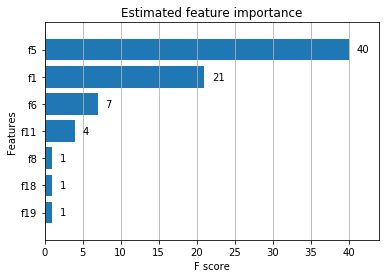

<IPython.core.display.Javascript object>

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title("Estimated feature importance")
plt.show()

In [45]:
y_pred = dask_xgboost.predict(client, bst, X_test_array).persist()
y_pred.compute()

array([0.48188978, 0.47597995, 0.4775207 , ..., 0.4775207 , 0.4775207 ,
       0.4775207 ], dtype=float32)

<IPython.core.display.Javascript object>

In [46]:
y_pred_int = (y_pred.compute() > 0.5).astype(np.int)
y_pred_int

array([0, 0, 0, ..., 0, 0, 0])

<IPython.core.display.Javascript object>

In [47]:
from sklearn.metrics import roc_curve

y_test, y_pred = dask.compute(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_pred)

<IPython.core.display.Javascript object>

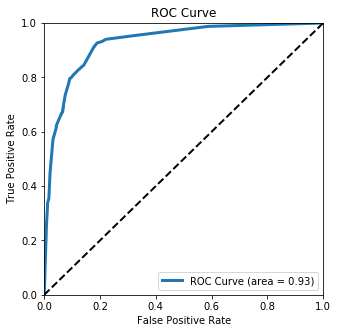

<IPython.core.display.Javascript object>

In [48]:
from sklearn.metrics import auc

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3, label="ROC Curve (area = {:.2f})".format(auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], "k--", lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend()
plt.show()

In [49]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test_array.compute(), y_pred_int)


array([[88596,  7205],
       [ 8431, 23078]], dtype=int64)

<IPython.core.display.Javascript object>

In [50]:
print(classification_report(y_test_array.compute(), y_pred_int))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     95801
           1       0.76      0.73      0.75     31509

    accuracy                           0.88    127310
   macro avg       0.84      0.83      0.83    127310
weighted avg       0.88      0.88      0.88    127310



<IPython.core.display.Javascript object>

### Random Forests and Logistic Regression

In [51]:
rfc = RandomForestClassifier()

<IPython.core.display.Javascript object>

In [52]:
rf_grid = {
    "max_depth": [4, 5, 6],
    "min_samples_split": [0.1, 0.2, 0.3],
    #'rf_clas__max_leaf_nodes': [],
    # "rf__max_samples": [0.2, 0.4, 0.6, 0.8],
    "max_features": [0.25, 0.5, 0.75],
}

<IPython.core.display.Javascript object>

In [53]:
rf_cv = GridSearchCV(rfc, rf_grid, cv=2, n_jobs=-1, verbose=1)

<IPython.core.display.Javascript object>

In [54]:
with joblib.parallel_backend("dask"):
    rf_cv.fit(X_train_array.compute(), y_train_array.compute())

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  6.8min finished


<IPython.core.display.Javascript object>

In [55]:
with joblib.parallel_backend("dask"):
    y_pred = rf_cv.predict(X_test_array)
    y_pred

<IPython.core.display.Javascript object>

In [56]:
rf_cv.best_params_

{'max_depth': 5, 'max_features': 0.5, 'min_samples_split': 0.3}

<IPython.core.display.Javascript object>

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90     95801
           1       0.77      0.52      0.62     31509

    accuracy                           0.84    127310
   macro avg       0.81      0.73      0.76    127310
weighted avg       0.84      0.84      0.83    127310



<IPython.core.display.Javascript object>

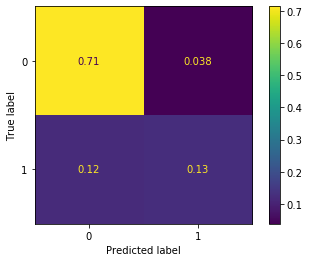

<IPython.core.display.Javascript object>

In [58]:
plot_confusion_matrix(rf_cv, X_test_array, y_test_array, normalize="all")

In [59]:
client.close()

distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 4 seconds, killing


<IPython.core.display.Javascript object>